<a href="https://colab.research.google.com/github/apoorvaec1030/Data-Science-projects/blob/main/NN_TensorFlow_Credit_Risk_PD_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Download the German Credit Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = [
    'existing_checking', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings', 'employment', 'installment_rate', 'personal_status', 'other_debtors',
    'residence_since', 'property', 'age', 'other_installments', 'housing',
    'existing_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'risk'
]

data = pd.read_csv(url, delimiter=' ', header=None, names=column_names)

In [4]:
# Convert target to binary (1 = bad risk, 0 = good risk)
data['risk'] = data['risk'] - 1  # Original is 1=good, 2=bad

# Separate categorical and numerical features
categorical_cols = [
    'existing_checking', 'credit_history', 'purpose', 'savings',
    'employment', 'personal_status', 'other_debtors', 'property',
    'other_installments', 'housing', 'job', 'telephone', 'foreign_worker'
]

numerical_cols = [
    'duration', 'credit_amount', 'installment_rate', 'residence_since',
    'age', 'existing_credits', 'people_liable'
]

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=categorical_cols)

# Split into features and target
X = data.drop('risk', axis=1)
y = data['risk']

# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [8]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

# First, let's modify our model compilation to include more metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                      keras.metrics.Precision(name='precision'),
                      keras.metrics.Recall(name='recall'),
                      keras.metrics.AUC(name='auc'),
                      keras.metrics.FalsePositives(name='fp'),
                      keras.metrics.FalseNegatives(name='fn')])

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    mode='max',
    restore_best_weights=True)

# Train the model with more detailed tracking
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5057 - auc: 0.5561 - fn: 45.1429 - fp: 126.4762 - loss: 0.7159 - precision: 0.3141 - recall: 0.5926 - val_accuracy: 0.6438 - val_auc: 0.7036 - val_fn: 23.0000 - val_fp: 34.0000 - val_loss: 0.6420 - val_precision: 0.4688 - val_recall: 0.5660
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5723 - auc: 0.5523 - fn: 49.4286 - fp: 98.7143 - loss: 0.6654 - precision: 0.3078 - recall: 0.5036 - val_accuracy: 0.7188 - val_auc: 0.7536 - val_fn: 20.0000 - val_fp: 25.0000 - val_loss: 0.6109 - val_precision: 0.5690 - val_recall: 0.6226
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5984 - auc: 0.6545 - fn: 43.6667 - fp: 94.8571 - loss: 0.6560 - precision: 0.3857 - recall: 0.5786 - val_accuracy: 0.7500 - val_auc: 0.7942 - val_fn: 17.0000 - val_fp: 23.0000 - val_loss: 0.5924 - val_precision: 0.6102 - val_recall: 0.6792
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6480 - auc: 0.6958 - fn: 35.8095 

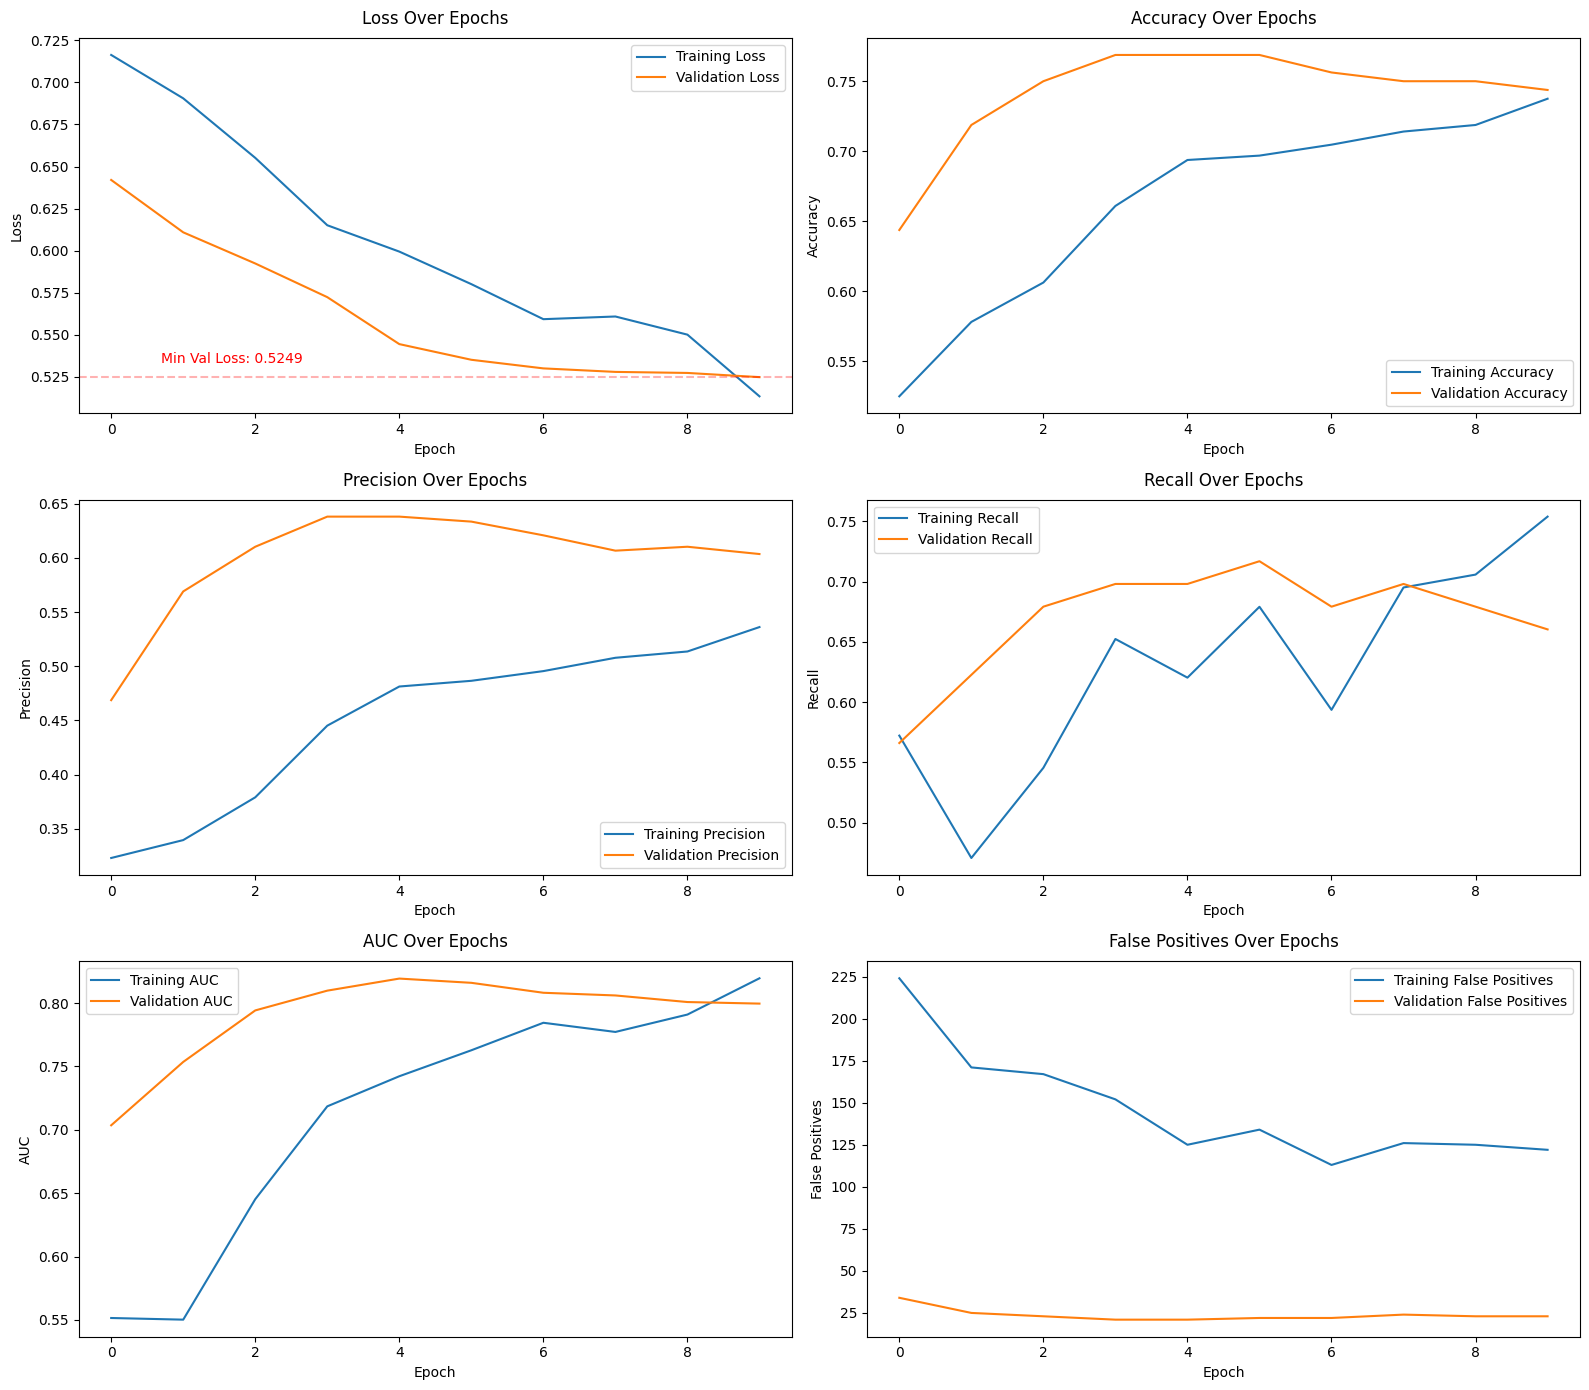

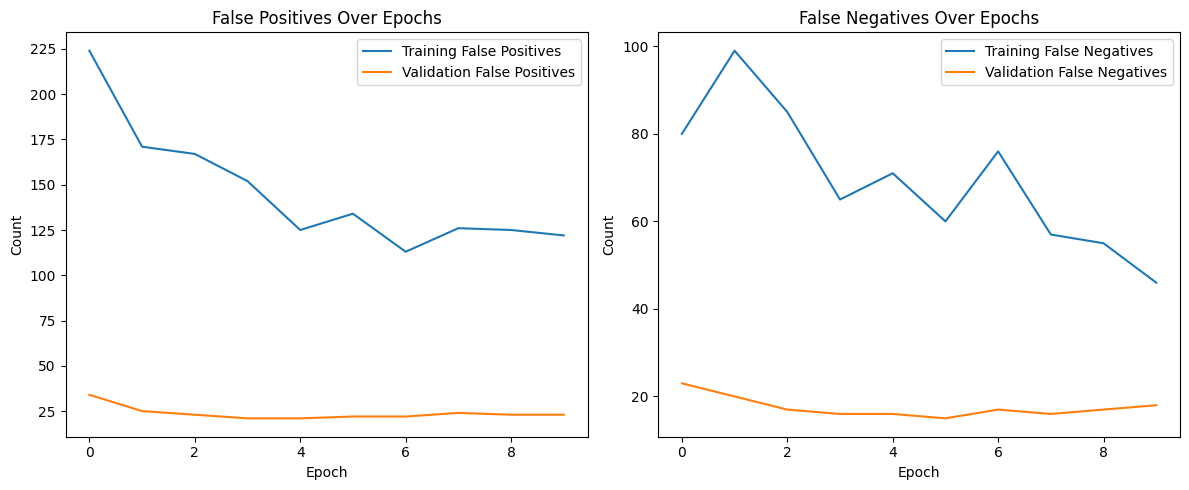

In [9]:
def plot_training_history(history):
    """Plot training and validation metrics across epochs"""

    # Create figure with subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Metrics to plot
    metrics = [
        ('loss', 'Loss'),
        ('accuracy', 'Accuracy'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('auc', 'AUC'),
        ('fp', 'False Positives')
    ]

    # Plot each metric
    for i, (metric, title) in enumerate(metrics):
        ax = axes[i]

        # Plot training metric
        ax.plot(history.history[metric], label=f'Training {title}')

        # Plot validation metric if it exists
        if f'val_{metric}' in history.history:
            ax.plot(history.history[f'val_{metric}'], label=f'Validation {title}')

        # Add decorations
        ax.set_title(title + ' Over Epochs', pad=10)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()

        # For loss, add a horizontal line at minimum validation loss
        if metric == 'loss' and 'val_loss' in history.history:
            min_val_loss = min(history.history['val_loss'])
            ax.axhline(y=min_val_loss, color='r', linestyle='--', alpha=0.3)
            ax.annotate(f'Min Val Loss: {min_val_loss:.4f}',
                        xy=(0.5, min_val_loss), xytext=(10, 10),
                        textcoords='offset points', color='r')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Additional plot for false positives/negatives
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['fp'], label='Training False Positives')
    if 'val_fp' in history.history:
        plt.plot(history.history['val_fp'], label='Validation False Positives')
    plt.title('False Positives Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['fn'], label='Training False Negatives')
    if 'val_fn' in history.history:
        plt.plot(history.history['val_fn'], label='Validation False Negatives')
    plt.title('False Negatives Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate the visualizations
plot_training_history(history)

In [6]:
# Calculate class weights (important for imbalanced data)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weights)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7017 - auc: 0.5807 - loss: 0.6453 - precision: 0.3283 - recall: 0.1614 - val_accuracy: 0.7250 - val_auc: 0.7545 - val_loss: 0.6270 - val_precision: 0.6552 - val_recall: 0.3585
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6123 - auc: 0.6343 - loss: 0.6736 - precision: 0.3823 - recall: 0.4261 - val_accuracy: 0.6812 - val_auc: 0.8082 - val_loss: 0.6315 - val_precision: 0.5119 - val_recall: 0.8113
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7129 - auc: 0.7438 - loss: 0.6176 - precision: 0.4954 - recall: 0.6546 - val_accuracy: 0.7375 - val_auc: 0.8084 - val_loss: 0.5884 - val_precision: 0.5821 - val_recall: 0.7358
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6858 - auc: 0.7347 - loss: 0.6225 - precision: 0.5012 - recall: 0.6528 - val_accuracy: 0.7750 - val_auc: 0.8163 - val_loss: 0.5615 - val_precision: 0.6349 - val_recall: 0.7547
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━

In [10]:
# Evaluate on test set
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7300
Test Precision: 0.5417
Test Recall: 0.6500
Test AUC: 0.7732
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Confusion Matrix:
[[107  33]
 [ 21  39]]


In [11]:
# Add to your imports
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

# Create a log directory with timestamp
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Add to your model.fit callbacks
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# To launch TensorBoard (run in terminal):
# tensorboard --logdir logs/fit

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7056 - auc: 0.7582 - fn: 37.3810 - fp: 67.3810 - loss: 0.5764 - precision: 0.4746 - recall: 0.6314 - val_accuracy: 0.7688 - val_auc: 0.8172 - val_fn: 15.0000 - val_fp: 22.0000 - val_loss: 0.5417 - val_precision: 0.6333 - val_recall: 0.7170
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6785 - auc: 0.7526 - fn: 35.3810 - fp: 71.6667 - loss: 0.5886 - precision: 0.4558 - recall: 0.6197 - val_accuracy: 0.7625 - val_auc: 0.8205 - val_fn: 15.0000 - val_fp: 23.0000 - val_loss: 0.5298 - val_precision: 0.6230 - val_recall: 0.7170
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7013 - auc: 0.8059 - fn: 30.4762 - fp: 71.4286 - loss: 0.5437 - precision: 0.5032 - recall: 0.6826 - val_accuracy: 0.7625 - val_auc: 0.8084 - val_fn: 16.0000 - val_fp: 22.0000 - val_loss: 0.5237 - val_precision: 0.6271 - val_recall: 0.6981
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7215 - auc: 0.8058 -

## **Simulating Synthetic Test Set**

In [12]:
import numpy as np
import pandas as pd

# Create synthetic test samples
sample_data = {
    'duration': np.random.randint(12, 72, 10),  # loan duration in months
    'credit_amount': np.random.randint(1000, 20000, 10),  # loan amount
    'installment_rate': np.random.randint(1, 4, 10),  # installment rate
    'residence_since': np.random.randint(1, 4, 10),  # years at residence
    'age': np.random.randint(25, 65, 10),  # applicant age
    'existing_credits': np.random.randint(1, 4, 10),  # existing credits
    'people_liable': np.random.randint(1, 3, 10),  # people liable
    'existing_checking_A11': np.random.choice([0, 1], 10),  # checking account status
    'existing_checking_A12': np.random.choice([0, 1], 10),
    'existing_checking_A13': np.random.choice([0, 1], 10),
    'existing_checking_A14': np.random.choice([0, 1], 10),
    'credit_history_A30': np.random.choice([0, 1], 10),  # credit history
    'credit_history_A31': np.random.choice([0, 1], 10),
    'credit_history_A32': np.random.choice([0, 1], 10),
    'credit_history_A33': np.random.choice([0, 1], 10),
    'credit_history_A34': np.random.choice([0, 1], 10),
    'purpose_A40': np.random.choice([0, 1], 10),  # loan purpose
    'purpose_A41': np.random.choice([0, 1], 10),
    'purpose_A42': np.random.choice([0, 1], 10),
    'purpose_A43': np.random.choice([0, 1], 10),
    'purpose_A44': np.random.choice([0, 1], 10),
    'purpose_A45': np.random.choice([0, 1], 10),
    'purpose_A46': np.random.choice([0, 1], 10),
    'purpose_A48': np.random.choice([0, 1], 10),
    'purpose_A49': np.random.choice([0, 1], 10),
    'savings_A61': np.random.choice([0, 1], 10),  # savings account
    'savings_A62': np.random.choice([0, 1], 10),
    'savings_A63': np.random.choice([0, 1], 10),
    'savings_A64': np.random.choice([0, 1], 10),
    'savings_A65': np.random.choice([0, 1], 10),
    'employment_A71': np.random.choice([0, 1], 10),  # employment status
    'employment_A72': np.random.choice([0, 1], 10),
    'employment_A73': np.random.choice([0, 1], 10),
    'employment_A74': np.random.choice([0, 1], 10),
    'employment_A75': np.random.choice([0, 1], 10),
    'personal_status_A91': np.random.choice([0, 1], 10),  # personal status
    'personal_status_A92': np.random.choice([0, 1], 10),
    'personal_status_A93': np.random.choice([0, 1], 10),
    'personal_status_A94': np.random.choice([0, 1], 10),
    'other_debtors_A101': np.random.choice([0, 1], 10),  # other debtors
    'other_debtors_A102': np.random.choice([0, 1], 10),
    'other_debtors_A103': np.random.choice([0, 1], 10),
    'property_A121': np.random.choice([0, 1], 10),  # property
    'property_A122': np.random.choice([0, 1], 10),
    'property_A123': np.random.choice([0, 1], 10),
    'property_A124': np.random.choice([0, 1], 10),
    'other_installments_A141': np.random.choice([0, 1], 10),  # other installments
    'other_installments_A142': np.random.choice([0, 1], 10),
    'other_installments_A143': np.random.choice([0, 1], 10),
    'housing_A151': np.random.choice([0, 1], 10),  # housing
    'housing_A152': np.random.choice([0, 1], 10),
    'housing_A153': np.random.choice([0, 1], 10),
    'job_A171': np.random.choice([0, 1], 10),  # job
    'job_A172': np.random.choice([0, 1], 10),
    'job_A173': np.random.choice([0, 1], 10),
    'job_A174': np.random.choice([0, 1], 10),
    'telephone_A191': np.random.choice([0, 1], 10),  # telephone
    'telephone_A192': np.random.choice([0, 1], 10),
    'foreign_worker_A201': np.random.choice([0, 1], 10),  # foreign worker
    'foreign_worker_A202': np.random.choice([0, 1], 10)
}

# Convert to DataFrame
sample_df = pd.DataFrame(sample_data)

# Ensure one-hot encoding constraints (only one category selected per feature)
for feature_group in ['existing_checking', 'credit_history', 'purpose', 'savings',
                     'employment', 'personal_status', 'other_debtors', 'property',
                     'other_installments', 'housing', 'job', 'telephone', 'foreign_worker']:
    cols = [c for c in sample_df.columns if c.startswith(feature_group)]
    sample_df[cols] = sample_df[cols].apply(lambda x: x == x.max(), axis=1).astype(int)

# Display the sample data
print("Sample test set:")
display(sample_df.head())

Sample test set:


,duration,credit_amount,installment_rate,residence_since,age,existing_credits,people_liable,existing_checking_A11,existing_checking_A12,existing_checking_A13,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_worker_A201,foreign_worker_A202
0,22,17430,1,2,33,2,2,0,0,0,...,0,1,1,1,0,1,0,1,1,0
1,54,7067,1,3,42,1,1,1,0,0,...,1,1,0,0,1,1,1,1,1,1
2,59,19015,1,1,51,2,1,0,1,1,...,1,1,1,0,0,1,1,0,0,1
3,35,6655,3,2,57,2,1,1,0,1,...,0,1,1,1,0,1,1,1,1,1
4,59,4512,1,3,62,3,2,1,1,0,...,1,1,0,1,1,1,1,0,1,0


In [13]:
# Normalize numerical features (using same scaler as training)
numerical_cols = ['duration', 'credit_amount', 'installment_rate',
                 'residence_since', 'age', 'existing_credits', 'people_liable']

sample_df[numerical_cols] = scaler.transform(sample_df[numerical_cols])

# Ensure all expected columns are present (add missing with 0 if needed)
missing_cols = set(X_train.columns) - set(sample_df.columns)
for col in missing_cols:
    sample_df[col] = 0

# Reorder columns to match training data
sample_df = sample_df[X_train.columns]

print("\nPreprocessed sample data:")
display(sample_df.head())


Preprocessed sample data:


,duration,credit_amount,installment_rate,residence_since,age,existing_credits,people_liable,existing_checking_A11,existing_checking_A12,existing_checking_A13,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.104150,5.329742,-1.727486,-0.747293,-0.210515,1.045047,2.291288,0,0,0,...,0,1,1,1,0,1,0,1,1,0
1,2.813732,1.451193,-1.727486,0.153060,0.604820,-0.718745,-0.436436,1,0,0,...,1,1,0,0,1,1,1,1,1,1
2,3.237105,5.922958,-1.727486,-1.647646,1.420155,1.045047,-0.436436,0,1,1,...,1,1,1,0,0,1,1,0,0,1
3,1.204918,1.296995,0.052281,-0.747293,1.963712,1.045047,-0.436436,1,0,1,...,0,1,1,1,0,1,1,1,1,1
4,3.237105,0.494936,-1.727486,0.153060,2.416676,2.808840,2.291288,1,1,0,...,1,1,0,1,1,1,1,0,1,0


In [21]:
# Get prediction probabilities
probabilities = model.predict(sample_df)

# Convert to risk classifications (using 0.5 threshold)
predictions = (probabilities > 0.5).astype(int)
'''
# Create interpretable results
results = pd.DataFrame({
    'Credit Amount': scaler.inverse_transform(sample_df)[:, 1],  # Reverse scaling
    'Duration (months)': scaler.inverse_transform(sample_df)[:, 0],
    'Age': scaler.inverse_transform(sample_df)[:, 4],
    'Probability of Default': probabilities.flatten(),
    'Predicted Risk': np.where(predictions == 1, 'High Risk', 'Low Risk')
})

# Add some interpretable features
results['Interest Rate'] = np.clip(5 + results['Probability of Default'] * 15, 5, 20)
results['Recommended Action'] = np.where(
    results['Predicted Risk'] == 'High Risk',
    'Reject or request collateral',
    'Approve with standard terms'
)

print("\nPrediction results:")
display(results.sort_values('Probability of Default', ascending=False))
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


'\n# Create interpretable results\nresults = pd.DataFrame({\n    \'Credit Amount\': scaler.inverse_transform(sample_df)[:, 1],  # Reverse scaling\n    \'Duration (months)\': scaler.inverse_transform(sample_df)[:, 0],\n    \'Age\': scaler.inverse_transform(sample_df)[:, 4],\n    \'Probability of Default\': probabilities.flatten(),\n    \'Predicted Risk\': np.where(predictions == 1, \'High Risk\', \'Low Risk\')\n})\n\n# Add some interpretable features\nresults[\'Interest Rate\'] = np.clip(5 + results[\'Probability of Default\'] * 15, 5, 20)\nresults[\'Recommended Action\'] = np.where(\n    results[\'Predicted Risk\'] == \'High Risk\',\n    \'Reject or request collateral\',\n    \'Approve with standard terms\'\n)\n\nprint("\nPrediction results:")\ndisplay(results.sort_values(\'Probability of Default\', ascending=False))\n'

In [17]:
predictions

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [18]:
sample_df

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,people_liable,existing_checking_A11,existing_checking_A12,existing_checking_A13,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.104150,5.329742,-1.727486,-0.747293,-0.210515,1.045047,2.291288,0,0,0,...,0,1,1,1,0,1,0,1,1,0
1,2.813732,1.451193,-1.727486,0.153060,0.604820,-0.718745,-0.436436,1,0,0,...,1,1,0,0,1,1,1,1,1,1
2,3.237105,5.922958,-1.727486,-1.647646,1.420155,1.045047,-0.436436,0,1,1,...,1,1,1,0,0,1,1,0,0,1
3,1.204918,1.296995,0.052281,-0.747293,1.963712,1.045047,-0.436436,1,0,1,...,0,1,1,1,0,1,1,1,1,1
4,3.237105,0.494936,-1.727486,0.153060,2.416676,2.808840,2.291288,1,1,0,...,1,1,0,1,1,1,1,0,1,0
5,-0.742595,5.307660,0.052281,-1.647646,-0.301108,-0.718745,2.291288,0,0,0,...,0,1,1,0,0,1,1,0,0,1
6,1.797639,3.372690,0.052281,0.153060,0.604820,1.045047,-0.436436,1,1,1,...,0,1,1,0,1,1,1,1,1,1
7,2.644383,5.301672,0.052281,-1.647646,0.604820,1.045047,-0.436436,1,1,1,...,0,1,0,1,1,1,1,0,0,1
8,1.882313,0.558936,-1.727486,0.153060,-0.844664,2.808840,-0.436436,0,0,1,...,0,1,1,1,1,1,1,1,1,0
9,1.966988,0.217603,0.052281,-0.747293,1.782526,1.045047,2.291288,1,1,0,...,1,0,1,0,1,0,1,0,1,1
